###setup

In [1]:
%matplotlib inline

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from numpy import array, inf, maximum
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import thunder
from showit import image, tile
import matplotlib.animation as animation

In [4]:
from os.path import join, exists
from os import mkdir, makedirs
import pandas as pd

In [5]:
import regression

In [6]:
import json

In [7]:
from skimage.io import imread, imsave

###set directory and session information

In [8]:
directory = '/tier2/freeman/Nick/lfov.calibration'

In [68]:
key = '2016-04-24-6-vision'
name = 'anm-0330549'

In [69]:
path = join(directory, 'reprocessed', name, key)

In [70]:
frameRate = 1.9

In [71]:
savepath = join(directory, 'reprocessed', name, key, 'summary')

###load covariates

In [72]:
covariates = pd.read_csv(join(path, 'covariates','covariates.csv'))

###load data

In [73]:
records = thunder.series.frombinary(join(path, 'traces', 'norm'), engine=None)

###load sources

In [74]:
from regional import many

In [75]:
tmp = []
for i in range(7):
    with open(join(path, 'sources', 'sources-%04i.json' % i), 'r') as fid:
        tmp.append(json.load(fid))
regions = many(tmp)

###load meta

In [76]:
with open(join(path, 'summary', 'meta.json')) as infile:
    meta = json.load(infile)

In [77]:
dims = meta['rois'][0]['npixels']
dims.reverse()

###load base images

In [78]:
#base = imread(join(path, 'summary', 'localcorrD.tif'))
#base = imread(join(path, 'summary', 'rsqOverlayLC.tif'))
base = imread(join(path, 'summary', 'tuneCorPosRD.tif'))

###plot traces

In [79]:
avg = records.mean().toarray()
avg.shape

(3734,)

In [80]:
len(covariates)

3734

(0, 500)

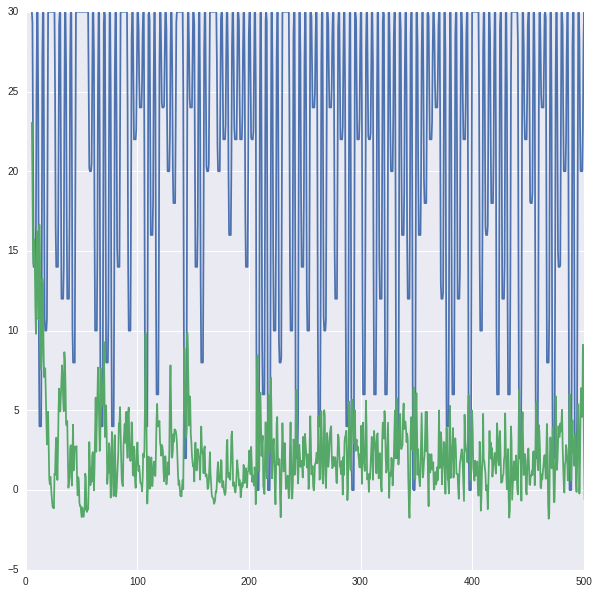

In [81]:
plt.figure(figsize=(10,10))
plt.plot(covariates.allTime, covariates.corPos);
plt.plot(covariates.allTime, 40*avg);
plt.xlim([0, 500])

##Pixelwise regression demo

In [82]:
import numpy as np
from matplotlib.pyplot import get_cmap
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from regression import LinearRegression

In [83]:
def build_bins(value, scale, debug=False):
    max_val = np.floor(max(value)/scale)*scale
    min_val = np.ceil(min(value)/scale)*scale
    bins = np.arange(min_val,max_val,scale)
    if debug:
        print 'bins:'
        print bins
    return bins

In [84]:
def build_mat(value, bins, debug=False):
    bins = np.concatenate((bins, [np.Inf]))
    design_mat = np.zeros([bins.shape[0] - 1,value.shape[0]])
    for bb in range(bins.shape[0] - 1):
        design_mat[bb,:] = (value >= bins[bb]) & (value < bins[bb+1])
    if debug:
        print 'repeats:'
        print design_mat.sum(axis=1)
    return design_mat.transpose()

In [85]:
def build_reg(value, scale, debug=False):
    bins = build_bins(value, scale, debug=False)
    design_mat = build_mat(value, bins, debug=False)
    return bins, design_mat

In [86]:
def do_reg(data, design_mat, bins):
    algorithm = LinearRegression(fit_intercept=False)
    model, rsq = algorithm.fit_and_score(design_mat, data)
    tune = model.betas.map(lambda b: sum(b.clip(0, inf)[1:]*bins)/sum(b.clip(0, inf)[1:]))
    return tune.toarray(), rsq.toarray(), model.betas.toarray()

In [87]:
def make_map(rsq, tune, cmap=None, vmin=0, vmax=inf, rmin=0, rmax=0.05):
    cmap = get_cmap('rainbow') if cmap is None else cmap
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    img = norm(tune.copy())
    mapped = cmap(img)[:, :, 0:3]
    for i in range(3):
        mapped[:, :, i] *= (rsq.clip(rmin, rmax) - rmin) / (rmax - rmin)
    return mapped

In [88]:
def make_rsq_map(rsq, cmap=None, vmin=0, vmax=inf, threshold=0.05):
    cmap = get_cmap('rainbow') if cmap is None else cmap
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    img = norm(rsq.copy())
    mapped = cmap(img)[:, :, 0:3]
    return mapped

### speed tuning maps

In [89]:
bins, design_mat = build_reg(covariates.speed.values, 4, debug=True)

In [90]:
tuning_speed, rsq_speed, betas_speed = do_reg(records, design_mat, bins)

In [91]:
tuning_speed

array([ 8.05257772,  7.22032975,  9.08106495,  8.87234288,  8.82490723,
        9.15046464,  8.770703  ])

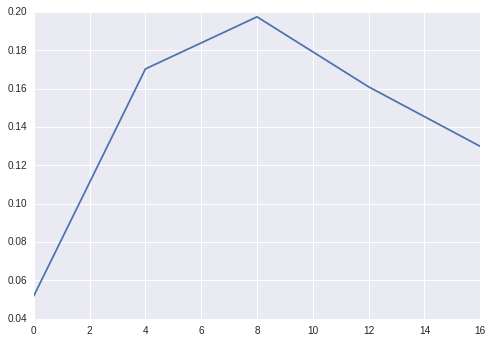

In [92]:
plt.plot(bins, betas_speed[4][1:])

###corridor position maps running

In [93]:
recordsR = records.map(lambda x: x[np.where((covariates.speed.values>0) & (covariates.samplePeriod.values == 1))])

In [94]:
recordsR

Series
mode: local
dtype: float64
shape: (7, 159)

In [95]:
bins = range(0,26,2)

In [96]:
design_mat = build_mat(covariates.corPos.values[(covariates.speed.values>0) & (covariates.samplePeriod.values == 1)], bins, debug=True)

repeats:
[ 18.  12.  13.  16.   8.  14.  10.  12.  11.   9.   4.  14.  18.]


In [97]:
tuning_corposR, rsq_corposR, betas_corposR = do_reg(recordsR, design_mat, bins)

In [98]:
tuning_corposR

array([  6.73157291,   6.43097723,  10.01909205,  10.15848493,
        13.24849227,  10.60679687,   6.25288805])

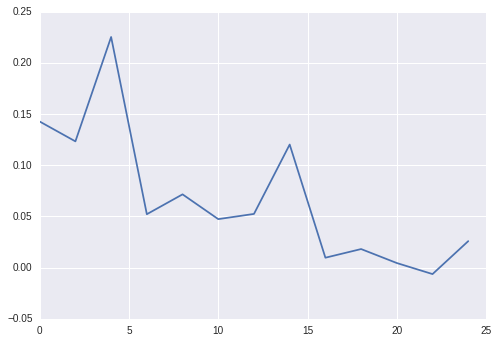

In [99]:
plt.plot(bins, betas_corposR[0][1:]);

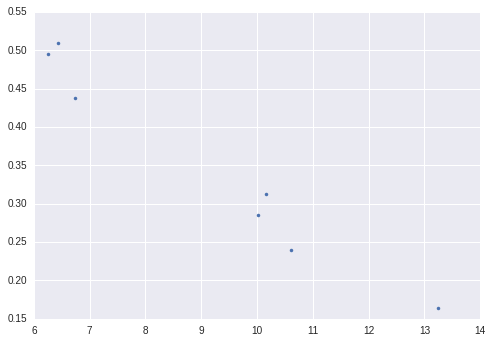

In [100]:
plt.plot(tuning_corposR, rsq_corposR, '.')

### corridor position maps

In [101]:
bins = range(0,26,2)

In [102]:
recordsC = records.map(lambda x: x[np.where(covariates.samplePeriod.values == 1)])

In [103]:
design_mat = build_mat(covariates.corPos.values[covariates.samplePeriod.values == 1], bins, debug=True)

repeats:
[ 117.  108.   91.  130.   80.  103.  109.  104.   87.  104.   96.  123.
  242.]


In [104]:
tuning_corpos, rsq_corpos, betas_corpos = do_reg(recordsC, design_mat, bins)

In [105]:
tuning_corpos

array([  8.84480316,   8.37776497,   9.57069647,  10.86243444,
        14.69207626,   9.65175146,   7.25007151])

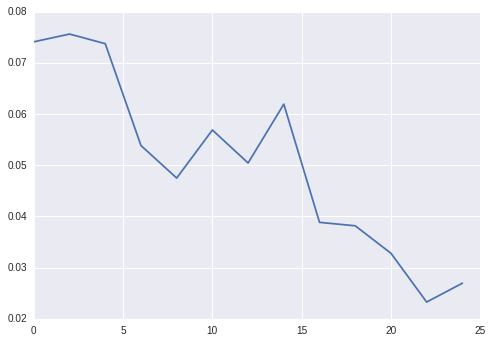

In [106]:
plt.plot(bins, betas_corpos[5][1:]);

##Summary

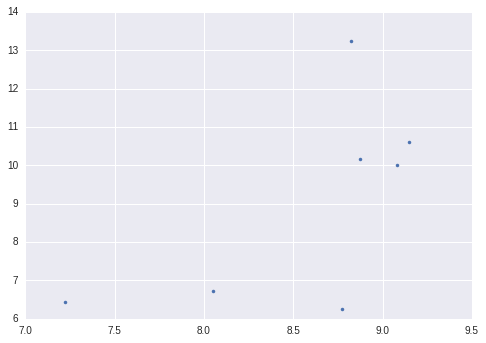

In [107]:
plt.plot(tuning_speed, tuning_corposR, '.')

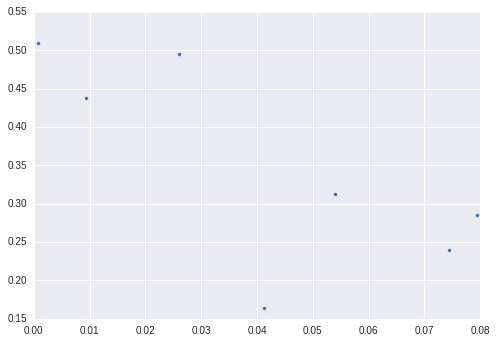

In [108]:
plt.plot(rsq_speed, rsq_corposR, '.')

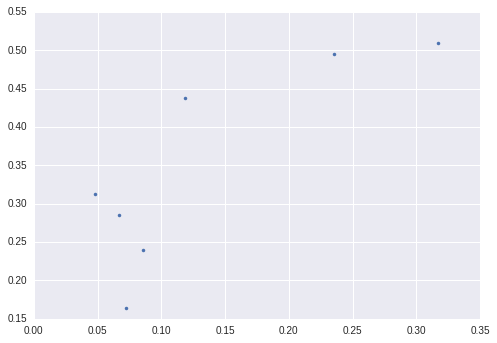

In [109]:
plt.plot(rsq_corpos, rsq_corposR, '.')

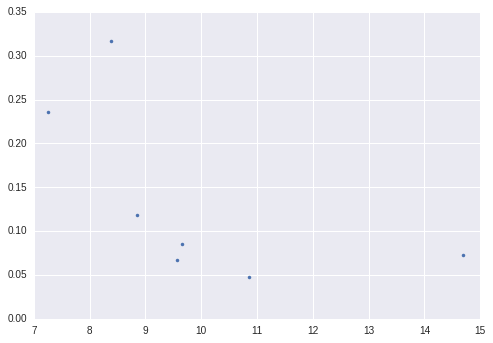

In [110]:
plt.plot(tuning_corpos, rsq_corpos, '.')

In [111]:
#(rsq_corpos.clip(a,b)-a)/b

In [112]:
v = tuning_corpos/30

In [113]:
masks = regions.mask(dims, background='black', cmap='rainbow', value=v)

In [114]:
background = np.tile((base.clip(.2,1)-.2)/(1-.2),(3,1,1)).transpose(1,2,0)

In [115]:
background = base.astype('float32')/255

In [116]:
blend = maximum(background, masks/2)

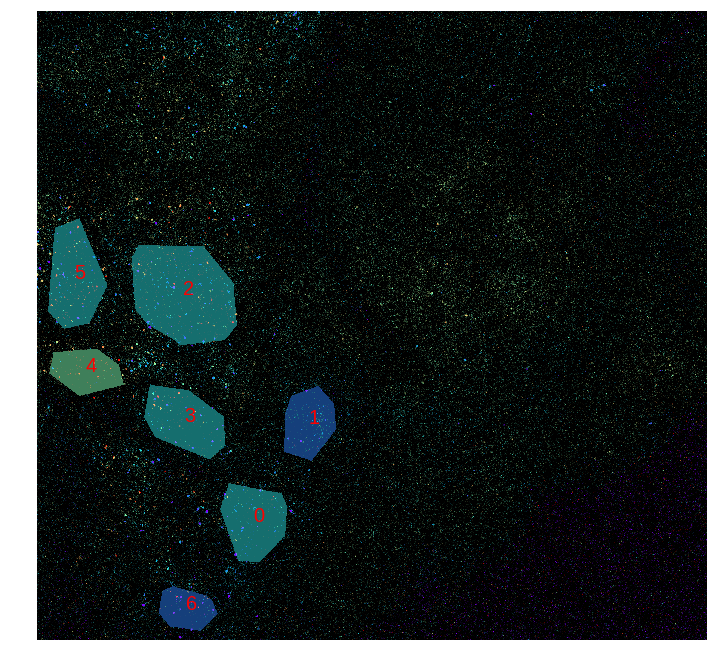

In [117]:
image(blend, size=12);
for s in range(regions.count):
    plt.annotate(s=str(s), xy=[regions.center[s][1],regions.center[s][0]], color='r', size = 20);

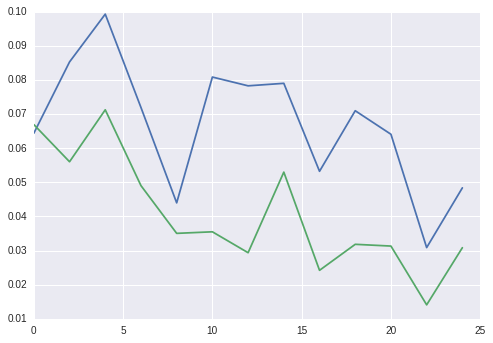

In [125]:
plt.plot(bins, betas_corpos[3][1:]);
plt.plot(bins, betas_corpos[2][1:]);

In [119]:
plt.plot(bins, betas_corpos[8][1:]);
plt.plot(bins, betas_corpos[4][1:]);

IndexError: index 8 is out of bounds for axis 0 with size 7

In [ ]:
#plt.plot(bins, betas_corposR[10][1:]);
plt.plot(bins, betas_corposR[0][1:]);
plt.plot(bins, betas_corposR[1][1:]);
plt.plot(bins, betas_corposR[2][1:]);
#plt.plot(bins, betas_corposR[5][1:]);
#plt.plot(bins, betas_corposR[6][1:]);

#plt.plot(bins, betas_corposR[3][1:]);
#plt.plot(bins, betas_corpos[5][1:]);
#plt.plot(bins, betas_corposR[7][1:]);
#plt.plot(bins, betas_corposR[3][1:]);


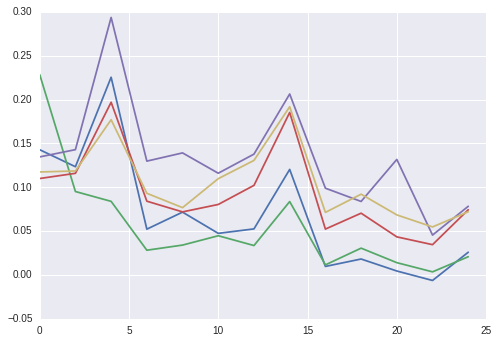

In [120]:
plt.plot(bins, betas_corposR[0][1:]);
plt.plot(bins, betas_corposR[1][1:]);
plt.plot(bins, betas_corposR[2][1:]);
plt.plot(bins, betas_corposR[3][1:]);
plt.plot(bins, betas_corposR[5][1:]);


ValueError: x and y must have same first dimension

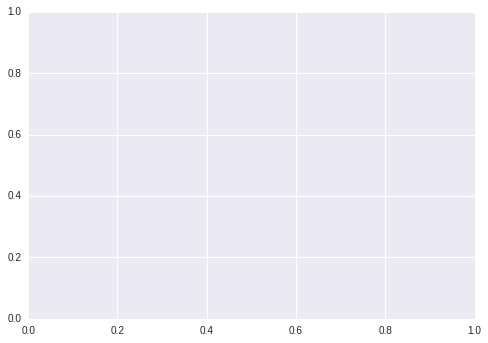

In [121]:
plt.plot(bins, betas_speed[3][1:]);
plt.plot(bins, betas_speed[6][1:]);
plt.plot(bins, betas_speed[8][1:]);

#plt.plot(bins, betas_speed[2][1:]);
#plt.plot(bins, betas_speed[5][1:]);

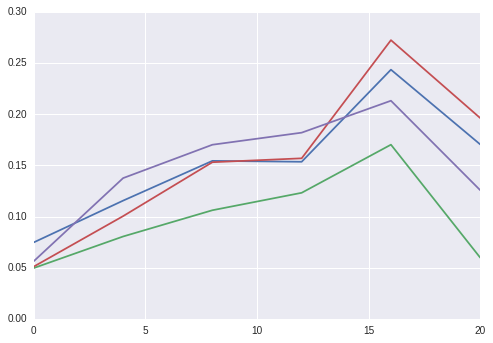

In [85]:
#plt.plot(bins, betas_corposR[10][1:]);
plt.plot(bins, betas_speed[0][1:]);
plt.plot(bins, betas_speed[1][1:]);
plt.plot(bins, betas_speed[2][1:]);
plt.plot(bins, betas_speed[5][1:]);
#plt.plot(bins, betas_corposR[6][1:]);

#plt.plot(bins, betas_corposR[3][1:]);
#plt.plot(bins, betas_corpos[5][1:]);
#plt.plot(bins, betas_corposR[7][1:]);
#plt.plot(bins, betas_corposR[3][1:]);


In [227]:
cmap = LinearSegmentedColormap.from_list('blend', [[0, 0, 0], [0.3, 0.7, 1.0]])
mapped_corpos = make_rsq_map(rsq_corpos, vmin=0, vmax=0.05, cmap=cmap)

In [228]:
#plt.hist(tuning_corpos[rsq_corpos>.0005].flatten())

In [230]:
imsave(savepath+'/rsqCorPosAD.tif', (255*mapped_corpos.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

In [231]:
#mapped_corpos = imread(savepath+'/rsqCorPosAD.tif', plugin='tifffile').astype('float32')/255

In [232]:
mapped = make_map(rsq_corpos, tuning_corpos, vmin=10.5, vmax = 13.5, rmin=0.008, rmax=0.05)

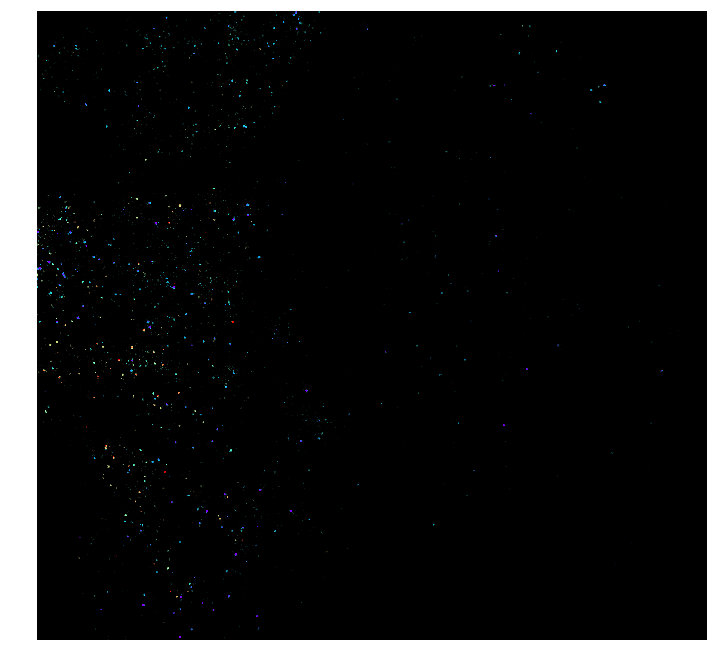

In [233]:
image(mapped.clip(0,1), size=12);

In [234]:
imsave(savepath+'/tuneCorPosAD.tif', (255*mapped.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

/usr/local/python-2.7.6/lib/python2.7/site-packages/scikit_image-0.11.3-py2.7-linux-x86_64.egg/skimage/io/_io.py:159: UserWarning: /tier2/freeman/Nick/lfov.calibration/reprocessed/anm-0330549-6/2016-04-24/summary/tuneCorPosAD.tif is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)


###overlay

In [235]:
overlay = maximum(mapped_corpos, mapped_speed)

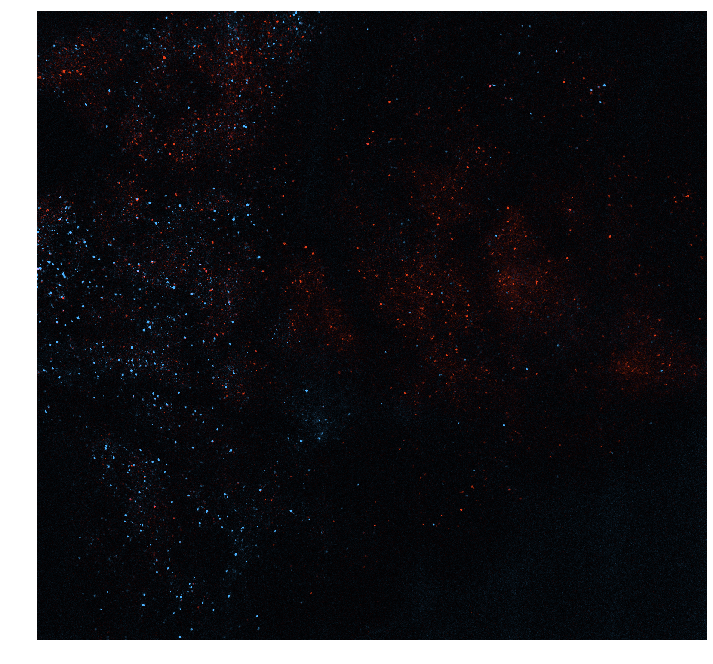

In [236]:
image(overlay, size=12)

In [237]:
imsave(savepath+'/rsqOverlayD.tif', (255*overlay).astype('uint8'), plugin='tifffile', photometric='rgb')

### localcorr map

In [238]:
localcorr = detrended.localcorr((4, 4)).astype('float32')

In [239]:
imsave(savepath+'/localcorrD.tif', localcorr, plugin='tifffile', photometric='minisblack')

In [240]:
#localcorr = imread(savepath+'/localcorrD.tif')

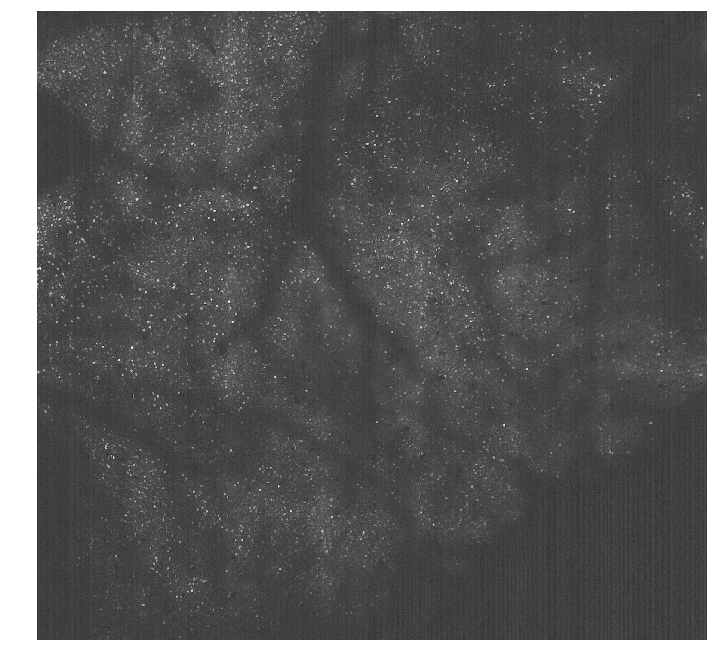

In [241]:
image(localcorr, clim=(0, 3.5*localcorr.mean()), size=12)

In [242]:
cmap = LinearSegmentedColormap.from_list('blend', [[0, 0, 0], [0.1, 1.0, 0.2]])
mapped_localcorr = make_rsq_map(localcorr, vmin=0.4, vmax=0.7, cmap=cmap)

##overlay

In [243]:
overlay = maximum(maximum(mapped_corpos, mapped_speed), mapped_localcorr)

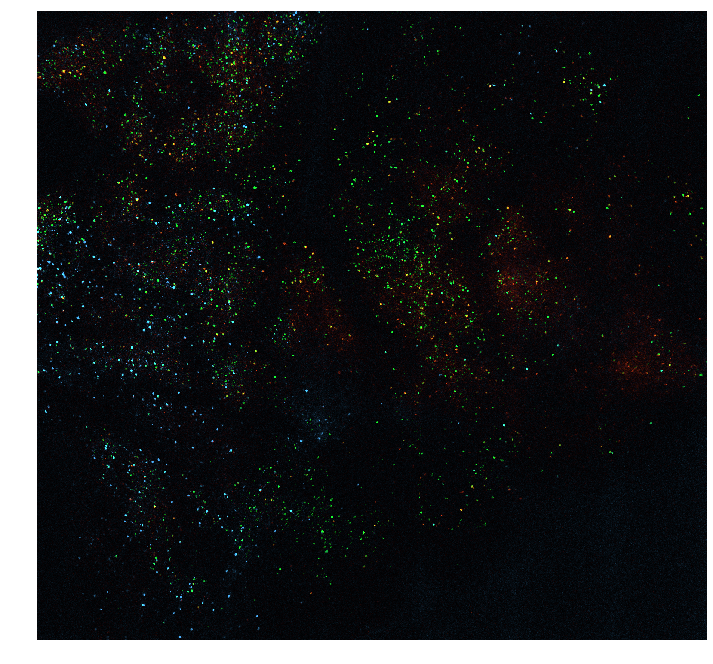

In [244]:
image(overlay, size=12);

In [245]:
imsave(savepath+'/rsqOverlayLCD.tif', (255*overlay).astype('uint8'), plugin='tifffile', photometric='rgb')

##tuning curves

In [246]:
#plt.plot(betasA[123,10,1,:])

In [247]:
#fig = plt.figure(figsize=[10,10])
#ax = plt.axes()
#im = image(betasA[:,:,0,2] - betasA[:,:,0,5], clim=(-125, 125), ax=ax)